In [56]:
import pandas as pd
import numpy as np
import random
random.seed(500)
np.random.seed(500)
import matplotlib.pyplot as plt


In [57]:
def check_bounds(ind):
    return  ind>=0 and ind<75

In [58]:
def split_to_states(agent_list):
    list_s, list_i, list_r = [],[],[]
    for agent in agent_list:
        if agent.state == "S": list_s.append(agent)
        elif agent.state=="I": list_i.append(agent)
        elif agent.state == "R": list_r.append(agent)
    return list_s, list_i, list_r

In [59]:
def plot_func(df_orig, title = ""):
    df = df_orig.copy()
    ax = df.plot(x="Time",
                  y=["Susceptible","Infected","Recovered"], 
                  color=["blue","red","green"])
    ax.set_xlabel("Time")
    ax.set_ylabel("Population Ratio")
    plt.title(title)

In [60]:
# TODO print_grid, How can I make the class agents unique?

In [71]:
class Agent_Environment:
    def __init__(self, x_size, y_size,  p=0.5, q = 0.5, social_distancing=False):
        self.grid = [[[] for _ in range(x_size)] for _ in range(y_size)]
        self.num_s = 0 
        self.num_i = 0
        self.num_r = 0
        self.p = p
        self.q = q
        self.all_agents = []
        self._get_all_agents()
        self.direction_choice_p = [0.2,0.2,0.2,0.2,0.2]

    # If social distancing is True
    # 1. reduced probability of moving at each step -> high probability of choosing "same" in possible directions list of [up, left, down, right,same] : (p(same) = 0.8 )
    # 2. agents actively move away from cells with infected individuals when possible -> reduce probability p that the susceptible agent becomes infected (default p = 0.1)
        if social_distancing: 
            self.direction_choice_p = [0.05, 0.05, 0.05, 0.05, 0.8] # correspoding to [up, left, down, right,same]
            self.p = 0.1 # reduce probability p that the susceptible agent becomes infected
        


    def _get_all_agents(self):
        self.all_agents = []
        for y_list in self.grid:
            for agents_list in y_list:
                for agent in agents_list:
                    self.all_agents.append(agent)
        
    def move_time_step(self, print_out=False):
        self.move_all_agents()
        self.update_transmission_recovery()
        assert len(self.all_agents) == (self.num_s+self.num_i + self.num_r)
        return self.get_stats(print_out)
    
    def get_stats(self, print_out=False):
        if print_out:
            print("Susceptible:", self.num_s)
            print("Infected:", self.num_i)
            print("Recovered:", self.num_r)
        return (self.num_s, self.num_i, self.num_r)
    
    def move_all_agents(self):
        # move all agents with random probability
        all_agents = list(self.all_agents)
        for agent in all_agents:
            agent.move()
        assert len(self.all_agents)==100

        
    def update_transmission_recovery(self):
        # update grid based on transmission and recovery
        for y_list in self.grid:
            for agents_list in y_list:
                list_s, list_i, list_r = split_to_states(agents_list)
                # if there are infectious agents
                if list_i:
                    # update S states with p probability
                    for s_agent in list_s:
                        s_agent.state = np.random.choice(["S", "I"], p=[1 - self.p, self.p])
                        if s_agent.state == "I":
                            self.num_i+=1
                            self.num_s-=1
                    # update infectious based on q to recover
                    for i_agent in list_i:
                        i_agent.state = np.random.choice(["I", "R"], p = [1-self.q, self.q])
                        if i_agent.state == "R":
                            self.num_r+=1
                            self.num_i-=1
    def print_grid(self):
        for y_list in self.grid:
            for agents_list in y_list:
                if not agents_list: print("000000", end="")
                else:
                    list_s, list_i, list_r = split_to_states(agents_list)
                    print(f"S{len(list_s)}I{len(list_i)}R{len(list_r)}", end="")
            print()


class Agent:
    _id_counter = 0
    def __init__(self, state, agent_env):
        self.state = state
        self.grid_x = -1
        self.grid_y = -1
        self.agent_env = agent_env
        self.id = Agent._id_counter
        Agent._id_counter+=1        

    def move(self):
        directions = ["up", "down", "left", "right", "same"]
        chosen_direction =  np.random.choice(directions, p = self.agent_env.direction_choice_p)
        new_x, new_y = self.grid_x, self.grid_y

        if chosen_direction=="up":
            if check_bounds(self.grid_y-1): new_y = self.grid_y-1
        elif chosen_direction =="down":
            if check_bounds(self.grid_y+1):new_y = self.grid_y +1
        elif chosen_direction=="left":
            if check_bounds(self.grid_x-1): new_x = self.grid_x-1
        elif chosen_direction =="right":
            if check_bounds(self.grid_x+1):new_x = self.grid_x+1
        # print(new_x, new_y, self.grid_x, self.grid_y)
        if (new_x, new_y)!= (self.grid_x, self.grid_y):
            # remove from the current grid position
            self.agent_env.grid[self.grid_y][self.grid_x].remove(self)
            # move to new grid position
            curr_agent_list =  self.agent_env.grid[new_y][ new_x]
            if self not in curr_agent_list:
                self.agent_env.grid[new_y][ new_x].append(self)
                self.grid_x  = new_x
                self.grid_y = new_y
    def add_to_grid(self, grid_x, grid_y):
        curr_agent_list =  self.agent_env.grid[grid_y][ grid_x]
        if self not in curr_agent_list:
            self.agent_env.grid[grid_y][ grid_x].append(self)
            self.grid_x  = grid_x
            self.grid_y = grid_y
            self.agent_env.num_s += self.state =="S"
            self.agent_env.num_r += self.state =="R"
            self.agent_env.num_i += self.state =="I"
            self.agent_env._get_all_agents()

    def __repr__(self): 
        return f"ID: {self.id}, State: {self.state}, Coordinates {self.grid_x, self.grid_y}"

In [ ]:
def run_trial(agent_env):
    create_populate_grid(agent_env)

In [72]:
def create_populate_grid(agent_env):
    susceptible_agents = [ Agent("S", agent_env) for i in range(95)]
    infected_agents = [Agent("I", agent_env) for i in range(5)]
    all_agents = susceptible_agents + infected_agents

    grid_coordinates = [(x,y )for x in range(75) for y in range(75)]
    random_indices = random.sample(grid_coordinates, 100)
    for i in range(100):
        rand_x, rand_y = random_indices[i][0], random_indices[i][1]
        all_agents[i].add_to_grid(rand_x, rand_y)

In [73]:
def simulate_time_steps(agent_env, step_size = 200):
    results_list = []
    for i in range(step_size):
        res = agent_env.move_time_step(print_out=False)
        results_list.append(res)
    return results_list

In [74]:
def generate_results_plot(p, q, show_plot=True):
    agent_env = Agent_Environment( x_size=75, y_size=75,  p=p, q=q)
    create_populate_grid(agent_env)
    results_list = simulate_time_steps(agent_env)
    df = pd.DataFrame(results_list, columns=["Susceptible", "Infected", "Recovered"])
    df["Time"] = df.index
    # print("p:", p, "q:", q)
    if show_plot:
        plot_func(df, title = f"p:{p}, q:{q}")
        plt.show()
    return df


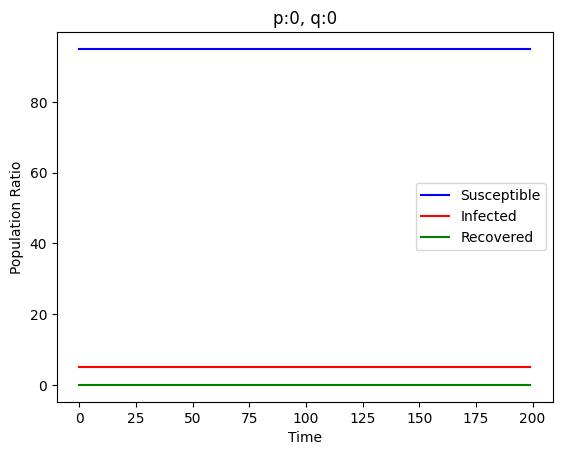

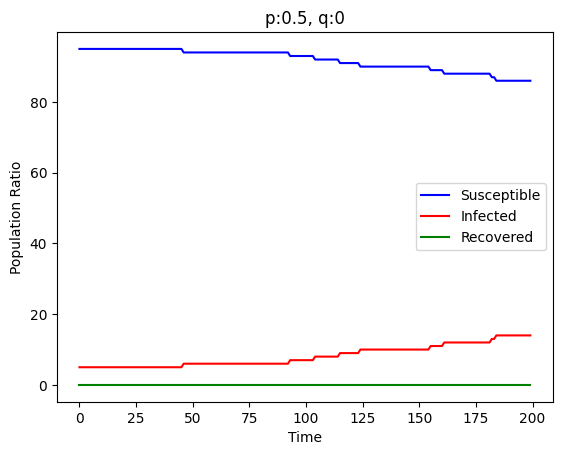

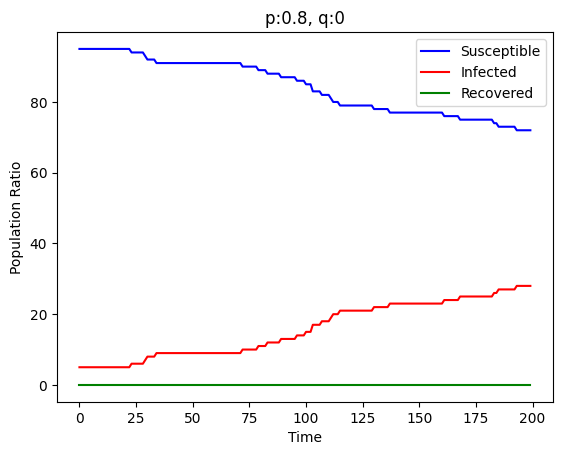

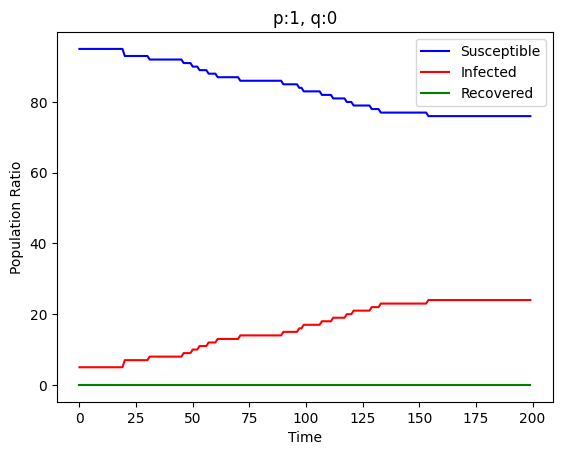

In [65]:
generate_results_plot(0,0)
generate_results_plot(0.5,0)
generate_results_plot(0.8,0)
_= generate_results_plot(1,0)


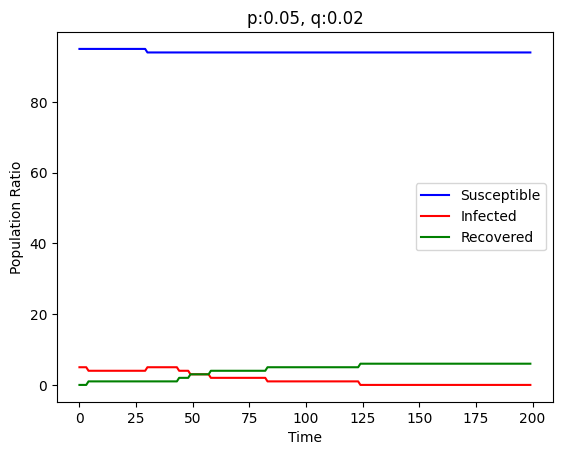

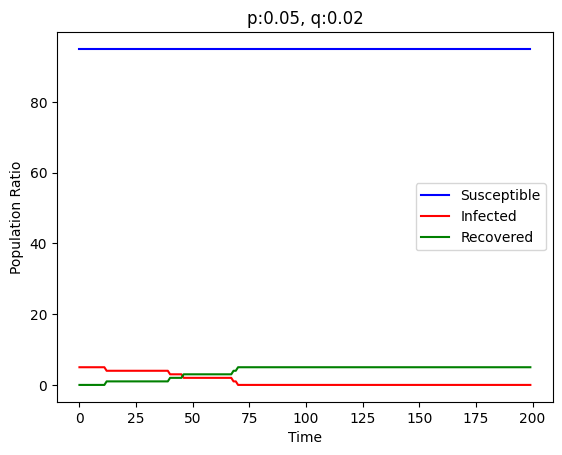

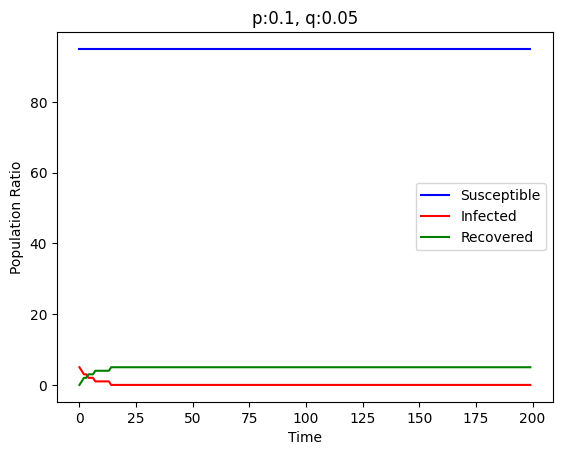

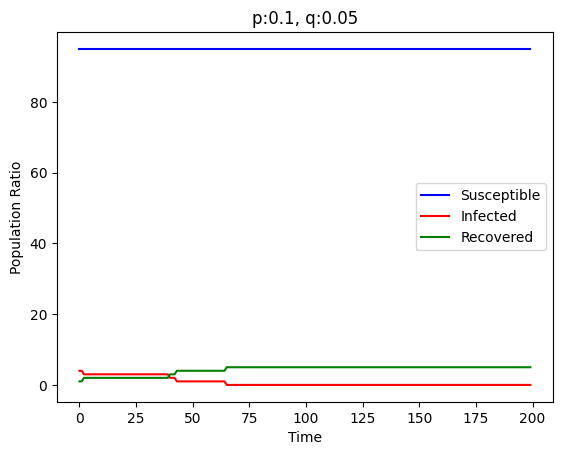

,Susceptible,Infected,Recovered,Time
0,95,4,1,0
1,95,4,1,1
2,95,3,2,2
3,95,3,2,3
4,95,3,2,4
...,...,...,...,...
195,95,0,5,195
196,95,0,5,196
197,95,0,5,197
198,95,0,5,198


In [66]:
generate_results_plot(0.05,0.02)
generate_results_plot(0.05,0.02)
generate_results_plot(0.1,0.05)
generate_results_plot(0.1,0.05)


In [67]:

p_s = np.random.ranf(100)
q_s = np.random.ranf(100)
trials = [(round(p_s[i],3), round(q_s[i],3)) for i in range(100)]
random_results = pd.DataFrame()
for p,q in trials:
    curr_r = generate_results_plot(p, q, show_plot=False)
    random_results = pd.concat([random_results, curr_r])

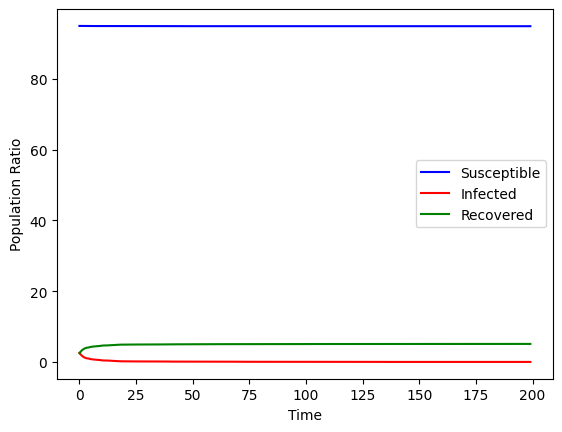

In [70]:
average_random_results = random_results.groupby("Time").mean().reset_index()
plot_func(average_random_results)

In [ ]:
class Agent_Environment_social_distancing:
    # changes
    # 1. reduced probability of moving at each step -> high probability of choosing "same" in possible directions list of [up, left, down, right,same] : (p(same) = 0.8 )
    # 2. agents actively move away from cells with infected individuals when possible -> reduce probability p that the susceptible agent becomes infected (default p = 0.1)
    def __init__(self, x_size, y_size,  p=0.1, q = 0.5):
        self.grid = [[[] for _ in range(x_size)] for _ in range(y_size)]
        self.num_s = 0 
        self.num_i = 0
        self.num_r = 0
        self.p = p
        self.q = q
        self.all_agents = []
        self._get_all_agents()

    def _get_all_agents(self):
        self.all_agents = []
        for y_list in self.grid:
            for agents_list in y_list:
                for agent in agents_list:
                    self.all_agents.append(agent)
        
    def move_time_step(self, print_out=False):
        self.move_all_agents()
        self.update_transmission_recovery()
        assert len(self.all_agents) == (self.num_s+self.num_i + self.num_r)
        return self.get_stats(print_out)
    
    def get_stats(self, print_out=False):
        if print_out:
            print("Susceptible:", self.num_s)
            print("Infected:", self.num_i)
            print("Recovered:", self.num_r)
        return (self.num_s, self.num_i, self.num_r)
    
    def move_all_agents(self):
        # move all agents with random probability
        all_agents = list(self.all_agents)
        for agent in all_agents:
            agent.move()
        assert len(self.all_agents)==100

        
    def update_transmission_recovery(self):
        # update grid based on transmission and recovery
        for y_list in self.grid:
            for agents_list in y_list:
                list_s, list_i, list_r = split_to_states(agents_list)
                # if there are infectious agents
                if list_i:
                    # update S states with p probability
                    for s_agent in list_s:
                        s_agent.state = np.random.choice(["S", "I"], p=[1 - self.p, self.p])
                        if s_agent.state == "I":
                            self.num_i+=1
                            self.num_s-=1
                    # update infectious based on q to recover
                    for i_agent in list_i:
                        i_agent.state = np.random.choice(["I", "R"], p = [1-self.q, self.q])
                        if i_agent.state == "R":
                            self.num_r+=1
                            self.num_i-=1
    def print_grid(self):
        for y_list in self.grid:
            for agents_list in y_list:
                if not agents_list: print("000000", end="")
                else:
                    list_s, list_i, list_r = split_to_states(agents_list)
                    print(f"S{len(list_s)}I{len(list_i)}R{len(list_r)}", end="")
            print()


class Agent_social_distancing:
    _id_counter = 0
    def __init__(self, state, agent_env):
        self.state = state
        self.grid_x = -1
        self.grid_y = -1
        self.agent_env = agent_env
        self.id = Agent._id_counter
        Agent._id_counter+=1        

    def move(self):
        directions = ["up", "down", "left", "right", "same"]
        chosen_direction =  np.random.choice(directions, p=[0.05, 0.05, 0.05, 0.05, 0.8])
        new_x, new_y = self.grid_x, self.grid_y
        new_x, new_y = self.grid_x, self.grid_y

        if chosen_direction=="up":
            if check_bounds(self.grid_y-1): new_y = self.grid_y-1
        elif chosen_direction =="down":
            if check_bounds(self.grid_y+1):new_y = self.grid_y +1
        elif chosen_direction=="left":
            if check_bounds(self.grid_x-1): new_x = self.grid_x-1
        elif chosen_direction =="right":
            if check_bounds(self.grid_x+1):new_x = self.grid_x+1
        # print(new_x, new_y, self.grid_x, self.grid_y)
        if (new_x, new_y)!= (self.grid_x, self.grid_y):
            # remove from the current grid position
            self.agent_env.grid[self.grid_y][self.grid_x].remove(self)
            # move to new grid position
            curr_agent_list =  self.agent_env.grid[new_y][ new_x]
            if self not in curr_agent_list:
                self.agent_env.grid[new_y][ new_x].append(self)
                self.grid_x  = new_x
                self.grid_y = new_y
    def add_to_grid(self, grid_x, grid_y):
        curr_agent_list =  self.agent_env.grid[grid_y][ grid_x]
        if self not in curr_agent_list:
            self.agent_env.grid[grid_y][ grid_x].append(self)
            self.grid_x  = grid_x
            self.grid_y = grid_y
            self.agent_env.num_s += self.state =="S"
            self.agent_env.num_r += self.state =="R"
            self.agent_env.num_i += self.state =="I"
            self.agent_env._get_all_agents()

    def __repr__(self): 
        return f"ID: {self.id}, State: {self.state}, Coordinates {self.grid_x, self.grid_y}"

In [ ]:

class Agent_social_distancing:
    _id_counter = 0
    def __init__(self, state, agent_env):
        self.state = state
        self.grid_x = -1
        self.grid_y = -1
        self.agent_env = agent_env
        self.id = Agent_social_distancing._id_counter
        Agent_social_distancing._id_counter+=1        
    def add_to_grid(self, grid_x, grid_y):
        curr_agent_list =  self.agent_env.grid[grid_y][ grid_x]
        if self not in curr_agent_list:
            self.agent_env.grid[grid_y][ grid_x].append(self)
            self.grid_x  = grid_x
            self.grid_y = grid_y
            self.agent_env.num_s += self.state =="S"
            self.agent_env.num_r += self.state =="R"
            self.agent_env.num_i += self.state =="I"
            # print("Susceptible:", self.agent_env.num_s)
            # print("Infected:", self.agent_env.num_i)
            # print("Recovered:", self.agent_env.num_r)
            # print("changed to",grid_x, grid_y)
        # else:
        #     print("Not changed")

    def move(self):
        directions = ["up", "down", "left", "right", "same"]
        # 1 change this
        chosen_direction =  np.random.choice(directions, p=[0.05, 0.05, 0.05, 0.05, 0.8])
        new_x, new_y = self.grid_x, self.grid_y

        if chosen_direction=="up":
            if check_bounds(self.grid_y-1): new_y = self.grid_y-1
        elif chosen_direction =="down":
            if check_bounds(self.grid_y+1):new_y = self.grid_y +1
        elif chosen_direction=="left":
            if check_bounds(self.grid_x-1): new_x = self.grid_x-1
        elif chosen_direction =="right":
            if check_bounds(self.grid_x+1):new_x = self.grid_x+1
        # print(new_x, new_y, self.grid_x, self.grid_y)
        if (new_x, new_y)!= (self.grid_x, self.grid_y):
            # remove from the current grid position
            self.agent_env.grid[self.grid_y][self.grid_x].remove(self)
            self.agent_env.num_s -= self.state =="S"
            self.agent_env.num_r -= self.state =="R"
            self.agent_env.num_i -= self.state =="I"
            # add to new grid position
            self.add_to_grid(new_x, new_y)

    def __repr__(self):
        return f"ID: {self.id}, State: {self.state}, Coordinates {self.grid_x, self.grid_y}"

In [ ]:
chosen_direction =  np.random.choice(directions, p=[0.05, 0.05, 0.05, 0.05, 0.8], size = 100)
chosen_direction

In [ ]:
def create_populate_grid_sd(agent_env):
    susceptible_agents = [ Agent_social_distancing("S", agent_env) for i in range(95)]
    infected_agents = [Agent_social_distancing("I", agent_env) for i in range(5)]
    all_agents = susceptible_agents + infected_agents

    grid_coordinates = [(x,y )for x in range(75) for y in range(75)]
    random_indices = random.sample(grid_coordinates, 100)
    for i in range(100):
        rand_x, rand_y = random_indices[i][0], random_indices[i][1]
        all_agents[i].add_to_grid(rand_x, rand_y)

In [ ]:
def simulate_time_steps(agent_env, step_size = 200):
    results_list = []
    for i in range(step_size):
        res = agent_env.move_time_step(print_out=False)
        results_list.append(res)
    return results_list

In [ ]:
def generate_results_plot(p, q, show_plot=True):
    agent_env = Agent_Environment( x_size=75, y_size=75,  p=p, q=q)
    create_populate_grid_sd(agent_env)
    results_list = simulate_time_steps(agent_env)
    df = pd.DataFrame(results_list, columns=["Susceptible", "Infected", "Recovered"])
    df["Time"] = df.index
    print("p:", p, "q:", q)
    if show_plot:
        df.plot(x="Time")
        plt.title(f"p:{p}, q:{q}")
        plt.show()
    return df


In [ ]:
# 2 lower p
generate_results_plot(0,0)
generate_results_plot(0.5,0)


In [ ]:
 np.random.uniform(low=0.0, high=0.5, size =100)

In [ ]:
p_s =  np.random.uniform(low=0.0, high=0.2, size =100)
q_s = np.random.ranf(100)
trials = [(round(p_s[i],3), round(q_s[i],3)) for i in range(100)]
random_results = pd.DataFrame()
for p,q in trials:
    curr_r = generate_results_plot(p, q, show_plot=False)
    random_results = pd.concat([random_results, curr_r])

In [ ]:
random_results

In [ ]:
average_random_results = random_results.groupby("Time").mean()
average_random_results.plot()